In [1]:
import os
from pathlib import Path

NOTEBOOK_PATH: Path = Path(os.path.abspath(''))

DATA_PATH: Path = NOTEBOOK_PATH.parent.joinpath('data')

PATH_FOR_RESULT: Path = NOTEBOOK_PATH.joinpath('RESULT')

if not PATH_FOR_RESULT.exists():
    PATH_FOR_RESULT.mkdir()

print(f'当前运行目录：{NOTEBOOK_PATH}')
print(f'当前数据目录：{DATA_PATH}')

当前运行目录：D:\Development\Python\InvestmentWorkshop\notebook
当前数据目录：D:\Development\Python\InvestmentWorkshop\data


# 缠论 B-01

B系列使用 pandas 读取数据并进行计算。

一步一步的手工计算。

## 准备

### 引用模块

In [2]:
import pandas as pd
import mplfinance as mpf

### 设置 pandas

In [3]:
pd.set_option('max_columns', None)
pd.set_option('display.width', 200)

### 设置 mplfinance

In [4]:
mpf_color = mpf.make_marketcolors(
    up='red',  # 上涨K线的颜色
    down='green',  # 下跌K线的颜色
    inherit=True
)

mpf_style = mpf.make_mpf_style(
    marketcolors=mpf_color,
    rc={
        'font.family': 'SimHei',       # 指定默认字体：解决plot不能显示中文问题
        'axes.unicode_minus': False,   # 解决保存图像是负号'-'显示为方块的问题
    }
)

### 声明数据

沪铝2112合约，2021-10-15 13:30:00 ~ 2021-10-19 00:59:00

In [5]:
# 代码：
symbol: str = 'SHFE.al2112'

# 周期:
period: str = 'Minute'

# 开始时间
datetime_start: str = '2021-10-15 13:30:00'

# 结束时间
datetime_end: str = '2021-10-19 00:59:00'

### 加载数据

In [6]:
def load_bar_data(data_file: Path, datetime_index: bool = True) -> pd.DataFrame:
    """
    加载 bar 数据为 pandas.DataFrame。
    :param data_file:
    :param datetime_index:
    :return:
    """
    if not data_file.exists():
        raise FileNotFoundError(f'{data_file} not found.')

    if datetime_index:
        return pd.read_csv(data_file, parse_dates=['datetime'], index_col=['datetime'])
    else:
        return pd.read_csv(data_file, parse_dates=['datetime'])

In [7]:
origin_data: pd.DataFrame = load_bar_data(DATA_PATH.joinpath(f'{symbol}_{period}.csv'))
df_ohlc: pd.DataFrame = origin_data.loc[datetime_start:datetime_end, ['open', 'high', 'low', 'close']]

df_ohlc.info()
print('-' * 100)
df_ohlc.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795 entries, 2021-10-15 13:30:00 to 2021-10-19 00:59:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    795 non-null    float64
 1   high    795 non-null    float64
 2   low     795 non-null    float64
 3   close   795 non-null    float64
dtypes: float64(4)
memory usage: 31.1 KB
----------------------------------------------------------------------------------------------------


,open,high,low,close
datetime,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0


### 定义计算结果

In [8]:
# df_tt 只是便于观察的中间结果。
df_tt: pd.DataFrame = pd.DataFrame(
    columns=['包含？', '本K更高？', '本K更低？', '前K本K方向', '合并后高点', '合并后低点', '合并后周期', '笔'],
    index=df_ohlc.index
)

df_tt.head(5)

,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,
2021-10-15 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 模拟处理

第一根K线，笔肯定无效。

第二根开始区分情况：

1. 无包含关系：
    1. 第二根的高点大于第一根的高点：笔的起始位置为第一根K线的低点，目前画向第二根K线的高点，为上升笔。
    2. 第二根的低点小于第一根的低点：笔的起始位置为第一根K线的高点，目前画向第二根K线的低点，为下降笔。
2. 有包含关系：
    不能确定。
    
**问题：第二根要不要合并？**

**回答：** 处理，但是因为不知道处理方向，就去最高点与最低点合并为一根K线。

In [9]:
def merge_candlestick(idx: int):
    """
    处理K线合并。
    """
    # ----------------------------------------
    # 第1根K线需要特殊处理。
    # ----------------------------------------
    if idx == 0:
        df_tt.iloc[idx].at['包含？'] = None
        df_tt.iloc[idx].at['本K更高？'] = None
        df_tt.iloc[idx].at['本K更低？'] = None
        df_tt.iloc[idx].at['前K本K方向'] = None
        df_tt.iloc[idx].at['合并后高点'] = df_ohlc.iloc[idx].at['high']
        df_tt.iloc[idx].at['合并后低点'] = df_ohlc.iloc[idx].at['low']
        df_tt.iloc[idx].at['合并后周期'] = 1
        df_tt.iloc[idx].at['笔'] = None
    else:
        print('比较：')
        print(f"\t前K：idx = {idx-1}, 高点 = {df_tt.iloc[idx-1].at['合并后高点']}, 低点 = {df_tt.iloc[idx-1].at['合并后低点']}")
        print(f"\t本K：idx = {idx}, 高点 = {df_ohlc.iloc[idx].at['high']}, 低点 = {df_ohlc.iloc[idx].at['low']}")
        
        # ----------------------------------------
        # 处理：包含。
        # ----------------------------------------
        
        # 本K线与前K线比较高点。
        df_tt.iloc[idx].at['本K更高？'] = True if df_ohlc.iloc[idx].at['high'] > df_tt.iloc[idx-1].at['合并后高点'] else False
        # 本K线与前K线比较低点。
        df_tt.iloc[idx].at['本K更低？'] = True if df_ohlc.iloc[idx].at['low'] < df_tt.iloc[idx-1].at['合并后低点'] else False
        
        # 本K线高点更高，低点更低，包含前K线。
        # 前K线高点更高，低点更低，包含本K线。
        # 其他情况均不包含。
        if (df_ohlc.iloc[idx].at['high'] >= df_tt.iloc[idx-1].at['合并后高点'] and df_ohlc.iloc[idx].at['low'] <= df_tt.iloc[idx-1].at['合并后低点']) or \
           (df_ohlc.iloc[idx].at['high'] <= df_tt.iloc[idx-1].at['合并后高点'] and df_ohlc.iloc[idx].at['low'] >= df_tt.iloc[idx-1].at['合并后低点']):
            df_tt.iloc[idx].at['包含？'] = True 
        else:
            df_tt.iloc[idx].at['包含？'] = False
        
        # ----------------------------------------
        # 处理：前K方向。
        # 前K方向有：
        # None（第1、2根K线）、包含、向上、向下
        # ----------------------------------------
        
        if df_tt.iloc[idx].at['包含？']:
            df_tt.iloc[idx].at['前K本K方向'] = '包含'
        else:
            if df_tt.iloc[idx].at['本K更高？']:
                df_tt.iloc[idx].at['前K本K方向'] = '向上'
            elif df_tt.iloc[idx].at['本K更低？']:
                df_tt.iloc[idx].at['前K本K方向'] = '向下'
#             # 取前K线的合并后周期。
#             d = df_tt.iloc[idx-1].at['合并后周期']
            
#             # 如果前根K线的合并后周期 == 本K线的 idx，表示在合并后，前面的K线全部被合并为一根，本K线为第二根。
#             if d == idx:
#                 # 从第1根K线起，到前1根K线的所有K线都被合并。
#                 # 只需比较当前K线和之前1根。
#                 df_tt.iloc[idx].at['前K本K方向'] = None
#             else:    
#                 # 前1根K线高点
#                 k1h = df_tt.iloc[idx-1].at['合并后高点']
#                 # 前1根K线低点
#                 k1l = df_tt.iloc[idx-1].at['合并后低点']
            
#                 # 前2根K线高点
#                 k2h = df_tt.iloc[idx-d].at['合并后高点']
#                 # 前2根K线低点
#                 k2l = df_tt.iloc[idx-d].at['合并后低点']

#                 if k1h > k2h and k1l > k2l:
#                     df_tt.iloc[idx].at['前K本K方向'] = '向上'
#                 elif k1h < k2h and k1l < k2l:
#                     df_tt.iloc[idx].at['前K本K方向'] = '向下'
#                 else:
#                     df_tt.iloc[idx].at['前K本K方向'] = '【出错啦】'
#                     print('【出错啦】')
#                     print(f'd = {d}')
#                     print(f'k1h = {k1h}')
#                     print(f'k1l = {k1l}')
#                     print(f'k2h = {k2h}')
#                     print(f'k2l = {k2l}')

        # ----------------------------------------
        # 处理：合并。
        # ----------------------------------------
        
        # # 第2根K线。
        # if df_tt.iloc[idx-1].at['前K本K方向'] is None:
        #     pass
#         if df_tt.iloc[idx].at['前K本K方向'] == '包含':
#             df_tt.iloc[idx].at['合并后周期'] = df_tt.iloc[idx-1].at['合并后周期'] + 1
#             # 本次合并的第一根K线的 idx。
#             x = idx - df_tt.iloc[idx-1].at['合并后周期']
#             # 本次合并的方向。
            
#             df_tt.iloc[idx].at['合并后高点'] = max(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
#             df_tt.iloc[idx].at['合并后低点'] = min(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
            
#         if df_tt.iloc[idx].at['前K本K方向'] == '向上':
#             df_tt.iloc[idx].at['合并后高点'] = max(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
#             df_tt.iloc[idx].at['合并后低点'] = max(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
#             df_tt.iloc[idx].at['合并后周期'] = 1
            
#         elif df_tt.iloc[idx].at['前K本K方向'] == '向下':
#             df_tt.iloc[idx].at['合并后高点'] = min(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
#             df_tt.iloc[idx].at['合并后低点'] = min(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
#             df_tt.iloc[idx].at['合并后周期'] = 1
        if df_tt.iloc[idx].at['前K本K方向'] == '包含':
            df_tt.iloc[idx].at['合并后周期'] = df_tt.iloc[idx-1].at['合并后周期'] + 1
            # 本次合并的第一根K线的 idx。
            x = idx - df_tt.iloc[idx-1].at['合并后周期']
            # 本次合并的方向。
            
            # 自开始的这一批合并。
            if df_tt.iloc[x].at['前K本K方向'] is None:
                df_tt.iloc[idx].at['合并后高点'] = max(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
                df_tt.iloc[idx].at['合并后低点'] = min(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
            elif df_tt.iloc[x].at['前K本K方向'] == '向上':
                df_tt.iloc[idx].at['合并后高点'] = max(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
                df_tt.iloc[idx].at['合并后低点'] = max(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
            
            elif df_tt.iloc[x].at['前K本K方向'] == '向下':
                df_tt.iloc[idx].at['合并后高点'] = min(df_tt.iloc[idx-1].at['合并后高点'], df_ohlc.iloc[idx].at['high'])
                df_tt.iloc[idx].at['合并后低点'] = min(df_tt.iloc[idx-1].at['合并后低点'], df_ohlc.iloc[idx].at['low'])
            
        else:
            df_tt.iloc[idx].at['合并后周期'] = 1
            df_tt.iloc[idx].at['合并后高点'] = df_ohlc.iloc[idx].at['high']
            df_tt.iloc[idx].at['合并后低点'] = df_ohlc.iloc[idx].at['low']

        df_tt.iloc[idx].at['笔'] = None

### 第1根

In [10]:
idx: int = 0
merge_candlestick(idx)

rows_to_watch: int = 5
result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第2根

In [11]:
idx = 1
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 0, 高点 = 23900.0, 低点 = 23840.0
	本K：idx = 1, 高点 = 23895.0, 低点 = 23845.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第3根

In [12]:
idx = 2
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 1, 高点 = 23900.0, 低点 = 23840.0
	本K：idx = 2, 高点 = 23895.0, 低点 = 23855.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第4根

In [13]:
idx = 3
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 2, 高点 = 23900.0, 低点 = 23840.0
	本K：idx = 3, 高点 = 23895.0, 低点 = 23840.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第5根

In [14]:
idx = 4
merge_candlestick(idx)

rows_to_watch = 10
result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 3, 高点 = 23900.0, 低点 = 23840.0
	本K：idx = 4, 高点 = 23855.0, 低点 = 23830.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第6根

In [15]:
idx = 5
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 4, 高点 = 23855.0, 低点 = 23830.0
	本K：idx = 5, 高点 = 23880.0, 低点 = 23830.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第7根

In [16]:
idx = 6
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 5, 高点 = 23855.0, 低点 = 23830.0
	本K：idx = 6, 高点 = 23900.0, 低点 = 23875.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第8根

In [17]:
idx = 7
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 6, 高点 = 23900.0, 低点 = 23875.0
	本K：idx = 7, 高点 = 23915.0, 低点 = 23880.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第9根

In [18]:
idx = 8
merge_candlestick(idx)

rows_to_watch = 15
result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 7, 高点 = 23915.0, 低点 = 23880.0
	本K：idx = 8, 高点 = 23890.0, 低点 = 23845.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第10根

In [19]:
idx = 9
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 8, 高点 = 23890.0, 低点 = 23845.0
	本K：idx = 9, 高点 = 23885.0, 低点 = 23860.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 画图

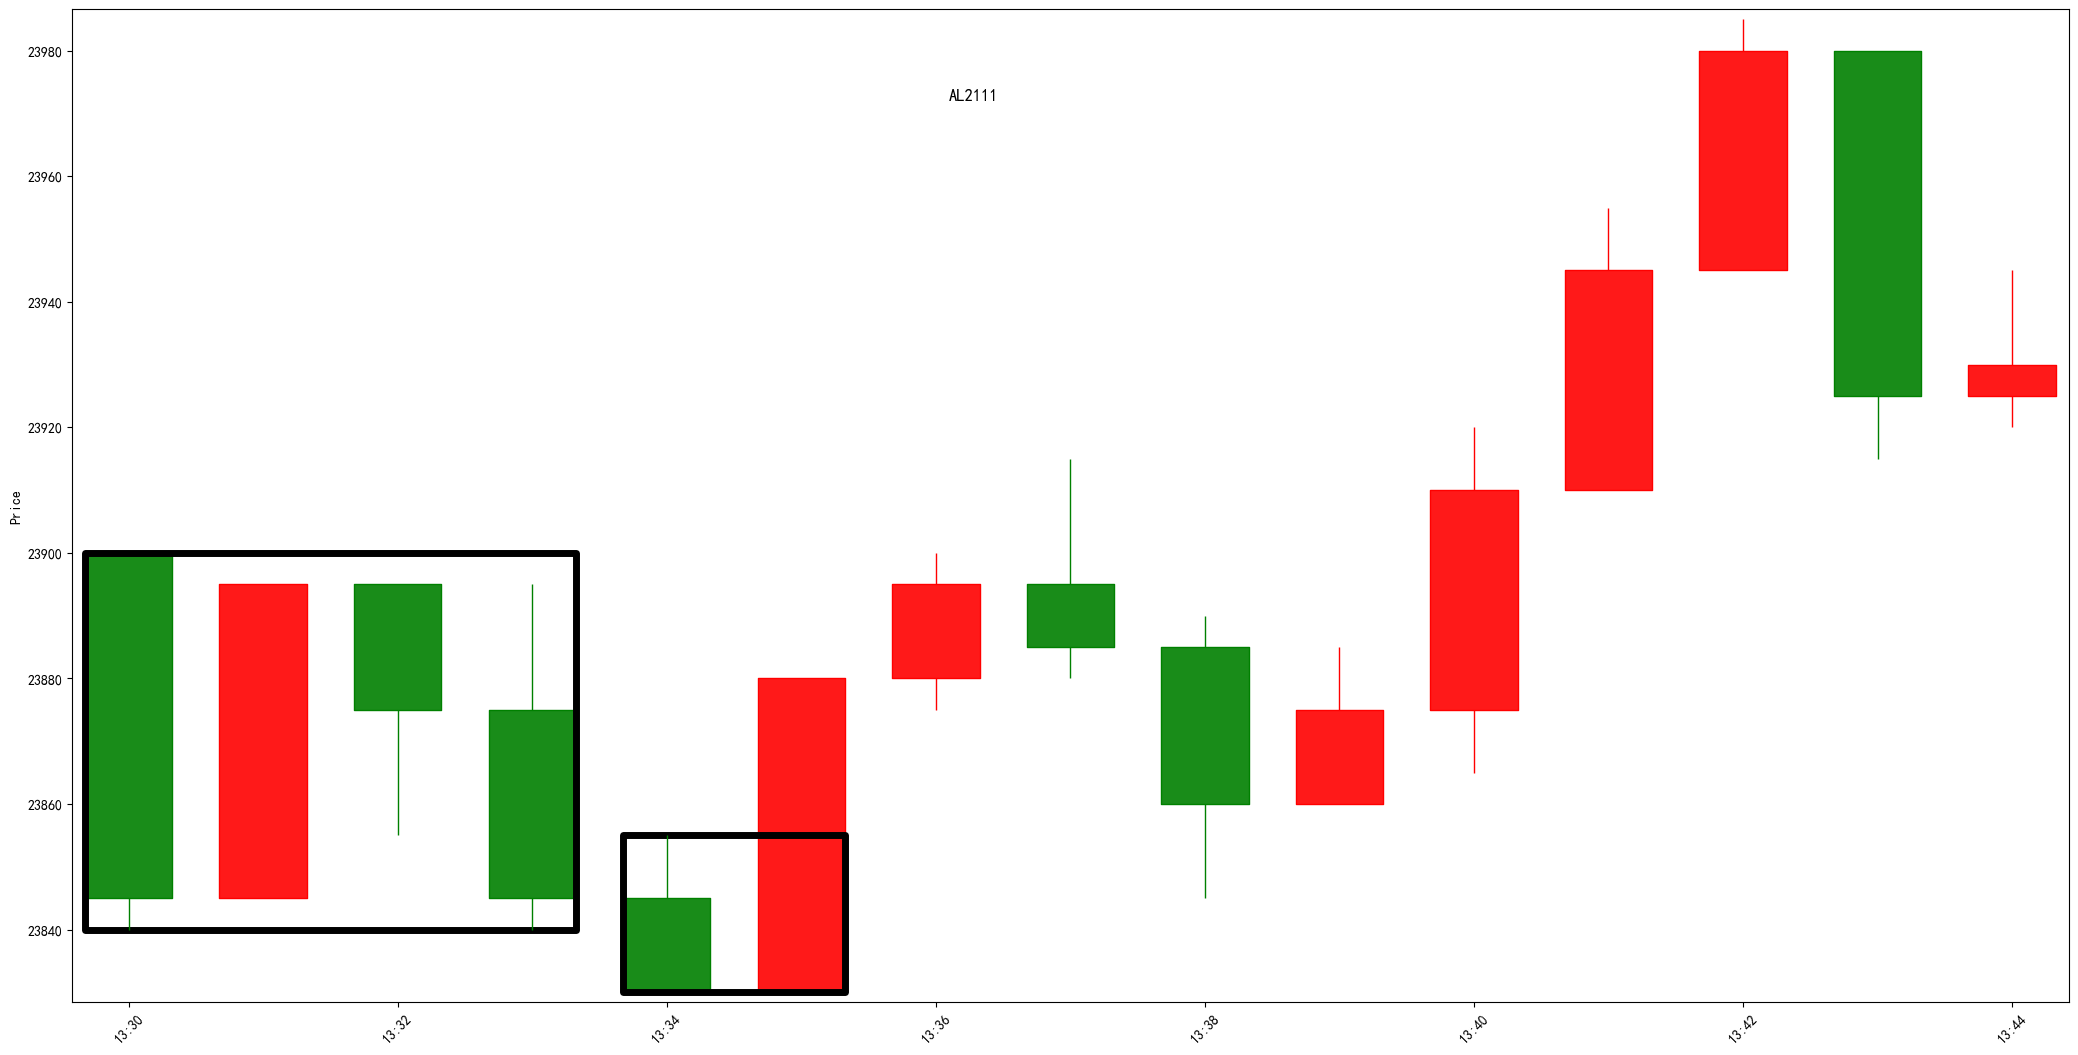

In [20]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def draw_candlestick(end: int):
    """
    绘制合并后的K线。
    """
    mpf_config = {}

    fig, ax_list = mpf.plot(
        df_ohlc.iloc[:end],
        title='AL2111',
        type='candle',
        volume=False,
        show_nontrading=False,
        figratio=(40, 20),
        figscale=2,
        style=mpf_style,
        tight_layout=True,
        returnfig=True,
        return_width_config=mpf_config
    )

    candle_width = mpf_config['candle_width']
    
    # 整理合并元素。
    merged_rectangle = []
    
    for idx in range(1, end):
        if pd.isna(df_tt.iloc[idx].at['合并后周期']):
            break
        if df_tt.iloc[idx].at['合并后周期'] == 1 and df_tt.iloc[idx-1].at['合并后周期'] > 1:
            x0 = idx - df_tt.iloc[idx-1].at['合并后周期'] - candle_width / 2
            y0 = df_tt.iloc[idx-1].at['合并后低点']
            w = df_tt.iloc[idx-1].at['合并后周期'] - 1 + candle_width
            h = df_tt.iloc[idx-1].at['合并后高点'] - df_tt.iloc[idx-1].at['合并后低点']
            merged_rectangle.append(
                Rectangle(xy=(x0, y0), width=w, height=h, angle=0)
            )
    
    # 生成矩形。
    patch_collection = PatchCollection(
        merged_rectangle,
        edgecolor='black',
        facecolor='none',
        linewidth=5
    )

    ax1 = ax_list[0]
    ax1.add_collection(patch_collection)
    ax1.autoscale_view()


draw_candlestick(rows_to_watch)

### 第11根

In [21]:
idx = 10
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 9, 高点 = 23885.0, 低点 = 23845.0
	本K：idx = 10, 高点 = 23920.0, 低点 = 23865.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第12根

In [22]:
idx = 11
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 10, 高点 = 23920.0, 低点 = 23865.0
	本K：idx = 11, 高点 = 23955.0, 低点 = 23910.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第13根

In [23]:
idx = 12
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 11, 高点 = 23955.0, 低点 = 23910.0
	本K：idx = 12, 高点 = 23985.0, 低点 = 23945.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第14根

In [24]:
idx = 13
merge_candlestick(idx)

rows_to_watch = 20
result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 12, 高点 = 23985.0, 低点 = 23945.0
	本K：idx = 13, 高点 = 23980.0, 低点 = 23915.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第15根

In [25]:
idx = 14
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 13, 高点 = 23980.0, 低点 = 23915.0
	本K：idx = 14, 高点 = 23945.0, 低点 = 23920.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 画图

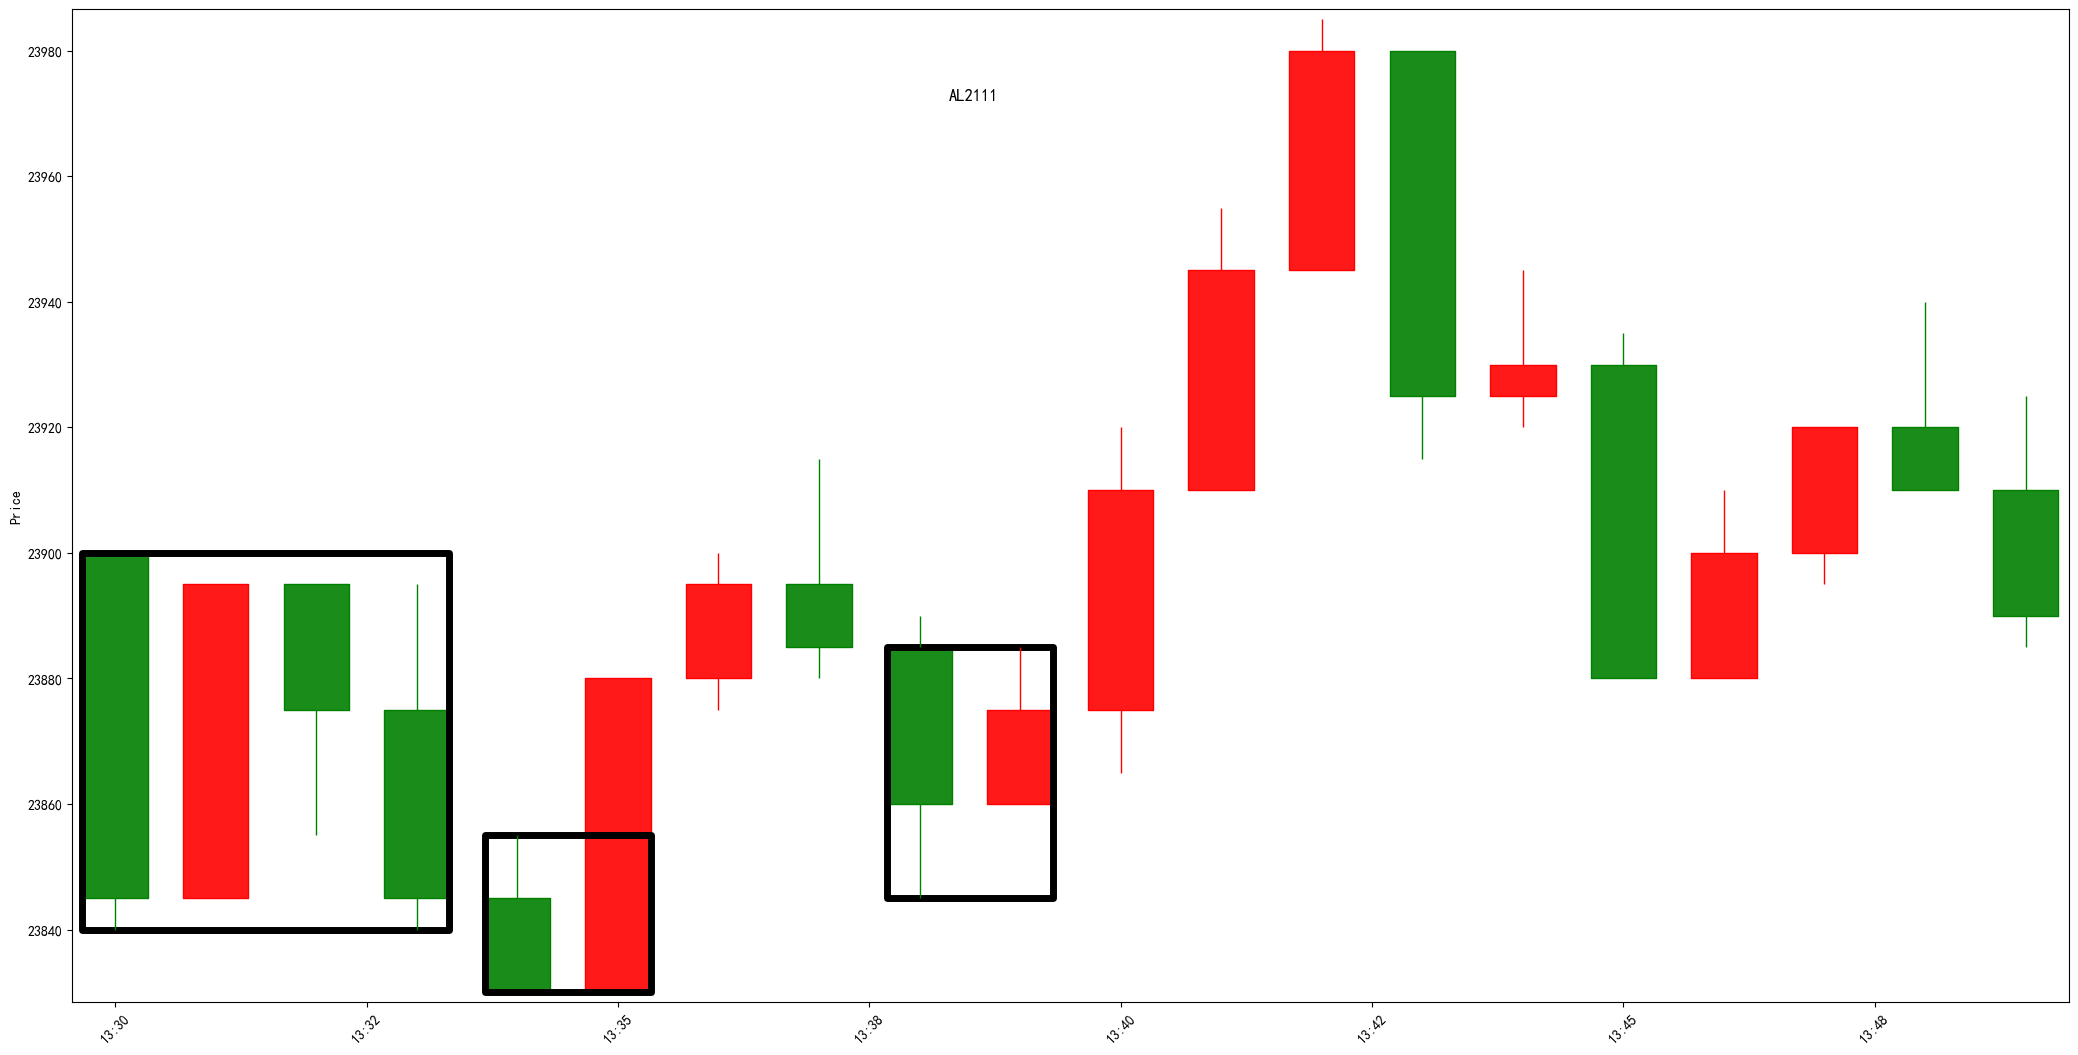

In [26]:
draw_candlestick(rows_to_watch)

### 第16根

In [27]:
idx = 15
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 14, 高点 = 23945.0, 低点 = 23915.0
	本K：idx = 15, 高点 = 23935.0, 低点 = 23880.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第17根

In [28]:
idx = 16
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 15, 高点 = 23935.0, 低点 = 23880.0
	本K：idx = 16, 高点 = 23910.0, 低点 = 23880.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第18根

In [29]:
idx = 17
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 16, 高点 = 23910.0, 低点 = 23880.0
	本K：idx = 17, 高点 = 23920.0, 低点 = 23895.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第19根

In [30]:
idx = 18
merge_candlestick(idx)

result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 17, 高点 = 23920.0, 低点 = 23895.0
	本K：idx = 18, 高点 = 23940.0, 低点 = 23910.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 第20根

In [31]:
idx = 19
merge_candlestick(idx)

rows_to_watch = 25
result = pd.concat([df_ohlc.iloc[:rows_to_watch], df_tt.iloc[:rows_to_watch]], axis=1)
result

比较：
	前K：idx = 18, 高点 = 23940.0, 低点 = 23910.0
	本K：idx = 19, 高点 = 23925.0, 低点 = 23885.0


,open,high,low,close,包含？,本K更高？,本K更低？,前K本K方向,合并后高点,合并后低点,合并后周期,笔
datetime,,,,,,,,,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0,None,None,None,None,23900.0,23840.0,1,None
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0,True,False,False,包含,23900.0,23840.0,2,None
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0,True,False,False,包含,23900.0,23840.0,3,None
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0,True,False,False,包含,23900.0,23840.0,4,None
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0,False,False,True,向下,23855.0,23830.0,1,None
2021-10-15 13:35:00,23830.0,23880.0,23830.0,23880.0,True,True,False,包含,23855.0,23830.0,2,None
2021-10-15 13:36:00,23880.0,23900.0,23875.0,23895.0,False,True,False,向上,23900.0,23875.0,1,None
2021-10-15 13:37:00,23895.0,23915.0,23880.0,23885.0,False,True,False,向上,23915.0,23880.0,1,None
2021-10-15 13:38:00,23885.0,23890.0,23845.0,23860.0,False,False,True,向下,23890.0,23845.0,1,None


### 画图

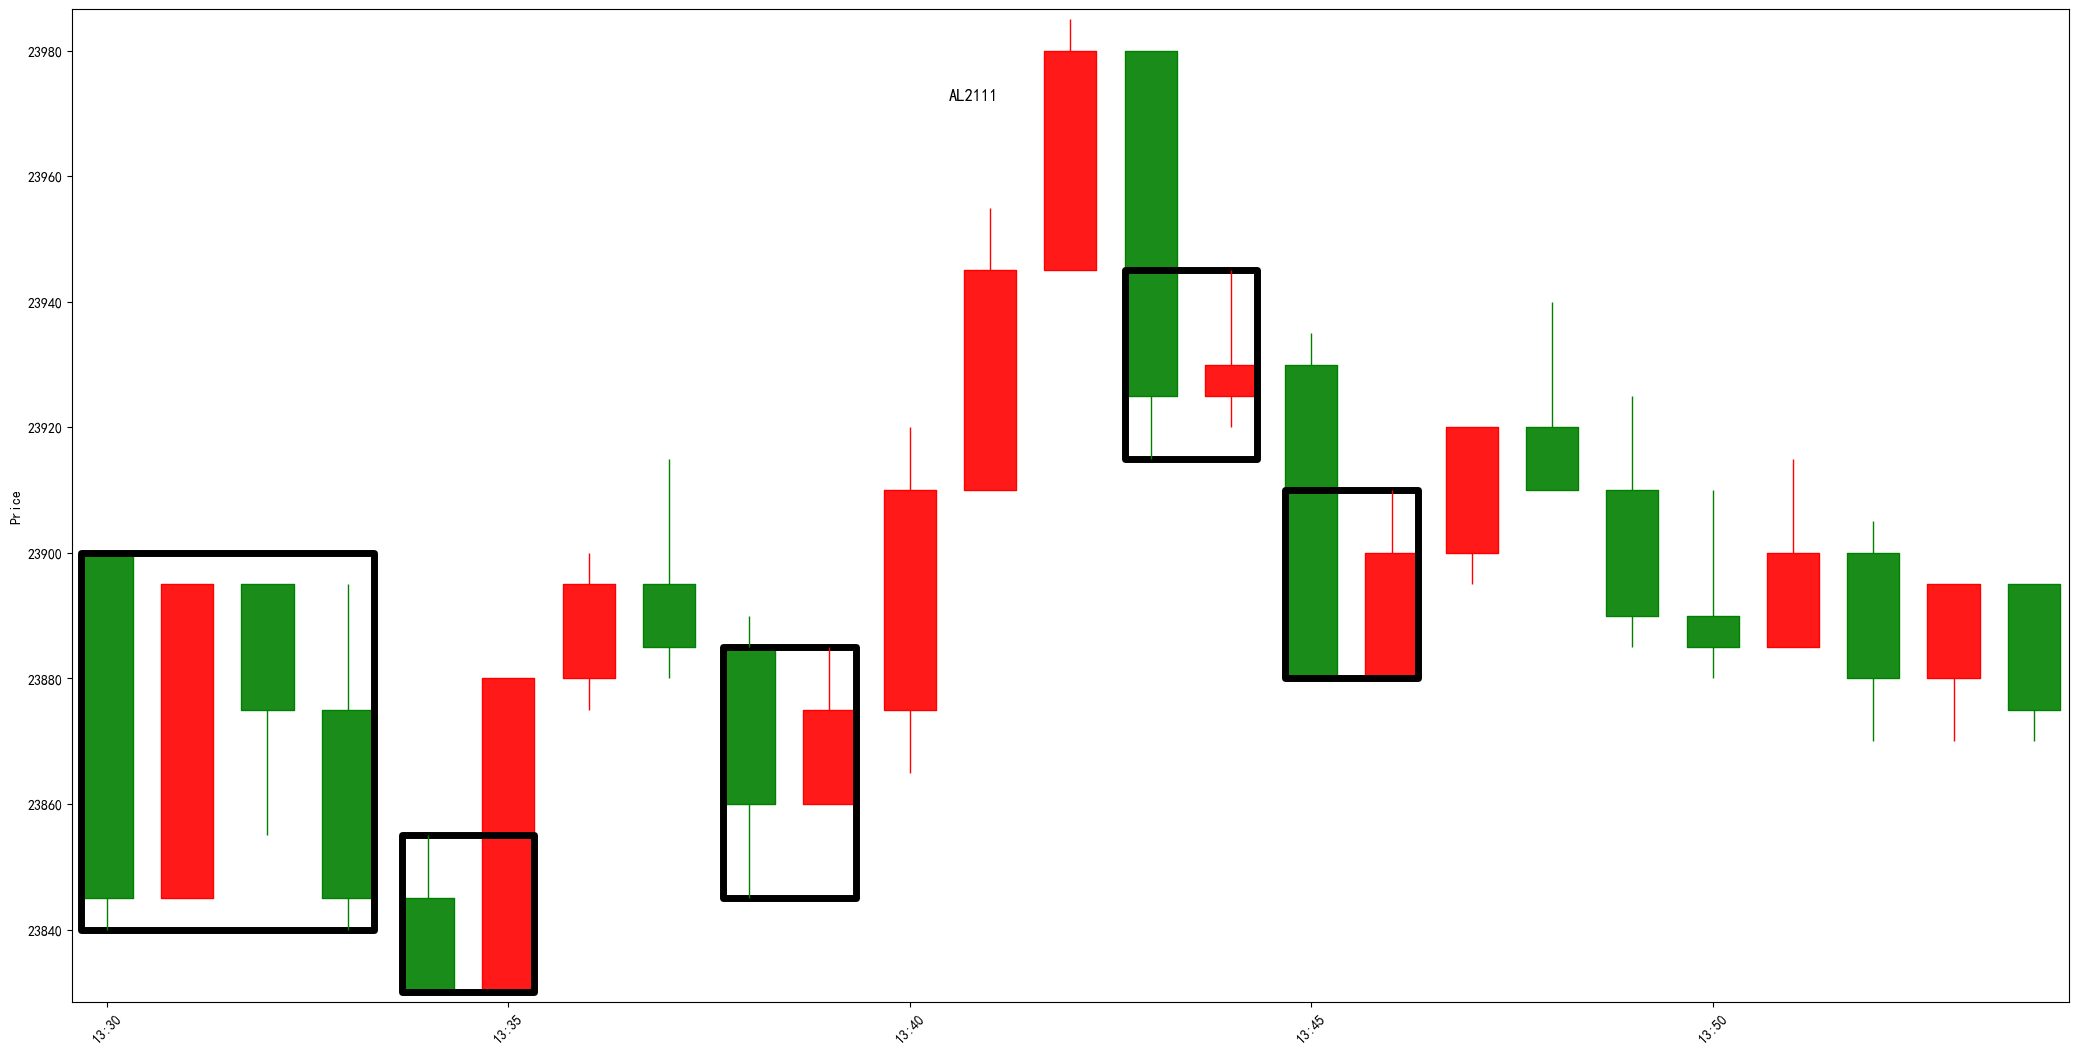

In [32]:
draw_candlestick(rows_to_watch)